In [1]:
# Importe les librairies
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
from itertools import compress
import mne

# Charge les données
fnirs_data_folder = mne.datasets.fnirs_motor.data_path()
fnirs_cw_amplitude_dir = op.join(fnirs_data_folder, 'Participant-1')
raw_intensity = mne.io.read_raw_nirx(fnirs_cw_amplitude_dir, verbose=True)
raw_intensity.load_data()
subjects_dir = op.join(mne.datasets.sample.data_path(), 'subjects')

# Améliore les annotations du jeu de données
raw_intensity.annotations.set_durations(5)
raw_intensity.annotations.rename({'1.0': 'Control',
                                  '2.0': 'Tapping/Left',
                                  '3.0': 'Tapping/Right'})
unwanted = np.nonzero(raw_intensity.annotations.description == '15.0')
raw_intensity.annotations.delete(unwanted)

# Visualize le montage

brain = mne.viz.Brain(
    'fsaverage', subjects_dir=subjects_dir, background='w', cortex='0.5')
brain.add_sensors(
    raw_intensity.info, trans='fsaverage',
    fnirs=['channels', 'pairs', 'sources', 'detectors'])
brain.show_view(azimuth=20, elevation=60, distance=400)

Loading /home/pbellec/mne_data/MNE-fNIRS-motor-data/Participant-1
Reading 0 ... 23238  =      0.000 ...  2974.464 secs...
Using pyvistaqt 3d backend.

Channel types::	fnirs_cw_amplitude: 56


Using matplotlib as 2D backend.


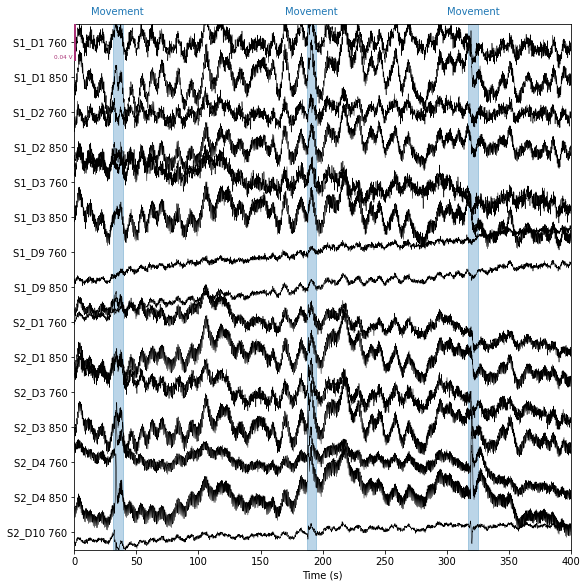

In [3]:
from mne.preprocessing.nirs import (optical_density,
                                    temporal_derivative_distribution_repair)
#fig = plt.figure(figsize=(10,3))
#plt.subplot(1, 2, 1)
raw_od = optical_density(raw_intensity)
new_annotations = mne.Annotations([31, 187, 317], [8, 8, 8],
                                  ["Movement", "Movement", "Movement"])
raw_od.set_annotations(new_annotations)
plt_od = raw_od.plot(n_channels=15, duration=400, show_scrollbars=False)

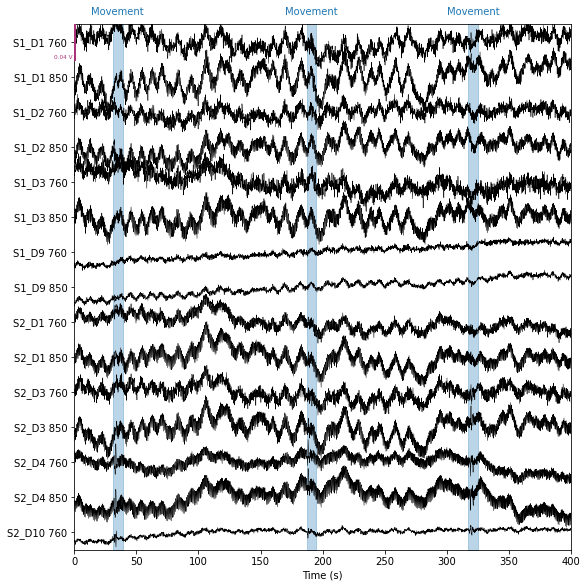

In [15]:
raw_tddr = temporal_derivative_distribution_repair(raw_od)
plot_tddr = raw_tddr.plot(n_channels=15, duration=400, show_scrollbars=False)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 sec)



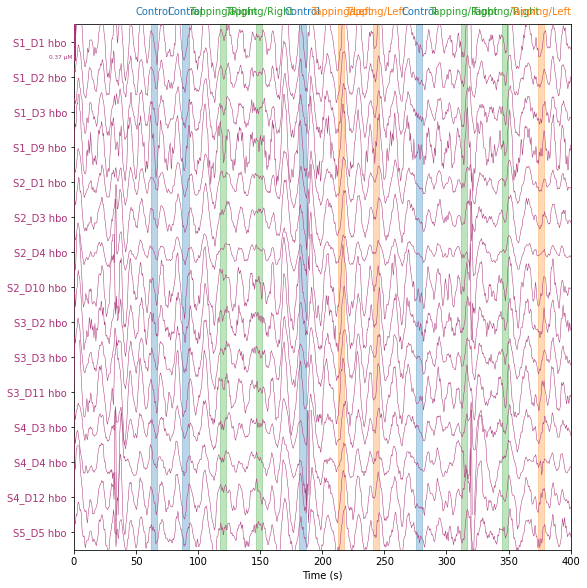

In [4]:
raw_od = optical_density(raw_intensity)
raw_tddr = temporal_derivative_distribution_repair(raw_od)
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=6)
raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
                             l_trans_bandwidth=0.02)
plot_hemo = raw_haemo.plot(n_channels=15, scalings='auto',
              duration=400, show_scrollbars=False)

Used Annotations descriptions: ['Control', 'Tapping/Left', 'Tapping/Right']
Not setting metadata
Not setting metadata
90 matching events found
Setting baseline interval to [-4.992, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 90 events and 157 original time points ...
0 bad epochs dropped
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


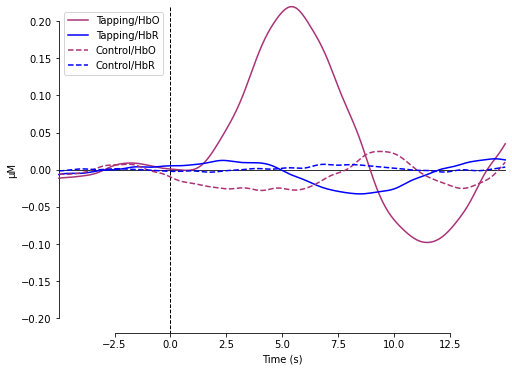

In [9]:
reject_criteria = dict(hbo=80e-6)
tmin, tmax = -5, 15
events, event_dict = mne.events_from_annotations(raw_haemo)

epochs = mne.Epochs(raw_haemo, events, event_id=event_dict,
                    tmin=tmin, tmax=tmax,
                    reject=reject_criteria, reject_by_annotation=True,
                    proj=True, baseline=(None, 0), preload=True,
                    detrend=None, verbose=True)

evoked_dict = {'Tapping/HbO': epochs['Tapping'].average(picks='hbo'),
               'Tapping/HbR': epochs['Tapping'].average(picks='hbr'),
               'Control/HbO': epochs['Control'].average(picks='hbo'),
               'Control/HbR': epochs['Control'].average(picks='hbr')}

# Rename channels until the encoding of frequency in ch_name is fixed
for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])

color_dict = dict(HbO='#AA3377', HbR='b')
styles_dict = dict(Control=dict(linestyle='dashed'))

plot_hrf = mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95,
                             colors=color_dict, styles=styles_dict)

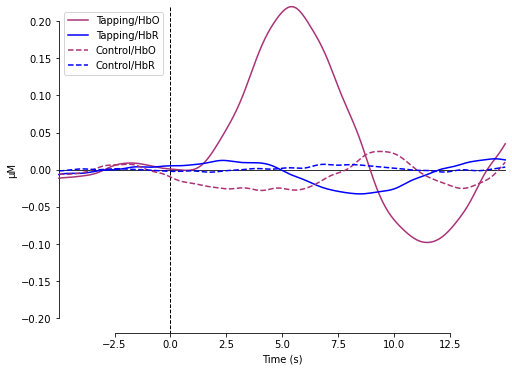

In [10]:
plot_hrf[0].savefig